In [1]:
# Import standard libraries
import time
import math
from math import pi
import itertools

# Import scientific libraries
import numpy as np
import scipy
import scipy.io

# Import and set up Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# Import standard Qiskit libraries
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, transpile, execute, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_textbook.tools import array_to_latex
 
%qiskit_version_table
%qiskit_copyright

In [2]:
provider = IBMQ.load_account()
# Get different simulation backends to play around with
# IBMQ.save_account('a4f980c0dc1a8f2a1d05236d0e7d6e8be273584a5b64e210c6ebdb62491e5eaaac71b60f139ab6fc9a13541e04cae04d54cef2b595e7bd0ed2793232e932707f', overwrite=True)
backends = provider.backends()
# backend_ibmq = backends[0]
# backend_ibmsv = backends[9]
# backend_ibmps = backends[10]
# backend_ibmes = backends[11]
backend_manila = backends[11]
backend_qasm  = Aer.get_backend('qasm_simulator')
backend_sv    = Aer.get_backend('statevector_simulator')
backend_un    = Aer.get_backend('unitary_simulator')
backends # list all backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [3]:
# Utility functions
def state_to_number(big_endian_state):
    """Convert a big-endian bitstring (Qiskit state representation) into an integer."""
    res = 0
    for i in range(len(big_endian_state)-1, -1, -1):
        res += 0 if big_endian_state[i] == '0' else 2**i
    return res

def order_by_stateval(statevector):
    """Order a statevector by its states converted to integers."""
    n = int(np.log2(len(statevector)))
#     assert n ** 2 == len(statevector)
    
    states = all_states(n)
    statenumbers = map(state_to_number, states)
    return [x for _, x in sorted(zip(statenumbers, statevector), key=lambda pair: pair[0])]

# Generate all states in statevector (in Qiskit order) based on number of qubits.
def all_states(n):
    return list(reversed(list(map(''.join, map(reversed, map(''.join, itertools.product('10', repeat=n)))))))

# Convert `result.get_counts` dict to probability vector, ordered in order of states.
def extract_statevector(count, n):
    keys = all_states(n)
    total = sum(count.values())
        
    reduced = {}
    
    for k in keys:
        reduced[k] = 0.0
    
    for (k, v) in count.items():
        reduced[k[-n:]] += v
    
    prob = []
    for k in keys:
        prob.append(reduced[k]/total)
    
    return order_by_stateval(prob)

# Convert `result.get_counts` in qiskit convension dict to probability vector, ordered in order of states.
def extract_statevector2(count, n):
    keys = all_states(n)
    total = sum(count.values())
        
    reduced = {}
    
    for k in keys:
        reduced[k] = 0.0
    
    for (k, v) in count.items():
        reduced[k[::-1]] += v
    
    prob = []
    for k in keys:
        prob.append(reduced[k]/total)
    
    return order_by_stateval(prob)



In [4]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    for i in range (n):
        circuit.h(i)
        m = 1
        for j in range (i+1,n):
            m = m +1; 
            circuit.cp(-2*pi/2**(m), i, j)
            
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def makeQFTgate(N):
    """returns a gate of centred QFT, swaps qubits"""
    temp = QuantumCircuit (N)
    swap_registers(temp, N)
    qft_rotations(temp,N)
    temp.x(n-1);
#     QFTC = temp.to_gate()
    return temp

In [5]:
def mcrz(circuit, angles, control, target):
    # The multiplexer RZ gate with arbitrary number of control bit. 
    if len(angles)!=2**len(control):
        # number of controlled state need to match number of angle
        raise Exception("Control bits and angles count don't match", angles, control)
    if len(angles)==1:
        # The MCRZ gate is identical to RZ gate when there is only a single angle
        circuit.rz(angles[0],target)
        return circuit
    angles1=[]
    angles2=[]
    # Fold angles list in half, each used to compute the less controlled MCRZ
    for i in range(0,len(angles)//2):
        angles1.append((angles[i]+angles[i+len(angles)//2])/2)
        angles2.append((angles[i]-angles[i+len(angles)//2])/2)
    # MC^nRZ gate can be decomposed as MC^(n-1)RZ * CX * MC^(n-1)RZ * CX
    mcrz(circuit, angles1, control[0:len(control)-1], target)
    circuit.cx(control[len(control)-1], target)
    mcrz(circuit, angles2, control[0:len(control)-1], target)
    circuit.cx(control[len(control)-1], target)
    return circuit

def extract_rz(phi1, phi2):
    # calculate phase difference and local phase
    phase = (phi1 + phi2) / 2.0
    z_angle = phi2 - phi1
    return phase, z_angle

def diagonal(circuit, diag, qubits):
    n = len(diag)
    totalq = len(qubits)
    nq = len(qubits)
    # Run until all "pair" are covered
    while n >= 2:
        angles_rz = []
        # Find phase difference and local phase for each pair
        for i in range(0, n, 2):
            diag[i // 2], rz_angle = extract_rz(diag[i], diag[i + 1])
            angles_rz.append(rz_angle)
        control = qubits[totalq - nq + 1:totalq]
        target = qubits[totalq - nq]
        mcrz(circuit, angles_rz, control, target)
#         circuit.barrier()
        n //= 2
        nq -= 1
    # Additional global phase so the diagonal matrix match exactly. Umimportant when diagonal matrix size match system size
    # But very important when the matrix only applies to certain qubits.
    circuit.global_phase += diag[0]
    return circuit

# Use multiple multiplexer RZ gate to create an diagonal
def produce_diag_U(n, rotations):
    q = QuantumRegister(n+1,'q')
    qc = QuantumCircuit(q)
    diagonal(qc, rotations, q[:n])
    return qc

In [7]:
def phase(n, dt):
    """returns the phase transformation gate for n qubits"""
    qc = QuantumCircuit(n+1);
    for i in range (n):
        qc.p(dt/(2**(i+n-3)), n-1-i)
    for i in range (n):
        for j in range (i+1,n):
            qc.cx(n-1-j, n)
            qc.cx(n-1-i, n)
            qc.p(dt* (2**(2-i-j)), n)
            qc.cx(n-1-i, n)
            qc.cx(n-1-j, n)
    return qc

In [8]:
def evolve (n,dt,iteration, timestep, initial_state, potential, backend, shots):
    ## make the circuit
    #qubits
    counts = []
    # gate setup
    QFT = makeQFTgate(n)
    kinetic = phase (n,dt)
    QFTi = QFT.inverse()
    potential = produce_diag_U(n, -potential)
    # iterations
    for i in range (timestep+1):
        q = QuantumRegister(n+1)
        c = ClassicalRegister(n)
        qc = QuantumCircuit(q, c)
        qc.barrier();
        
        #initialization
        qc.initialize(initial_state, q[:n]) 
        qc.barrier();
        
        #evolve
        for j in range(i*iteration):
            #QFT
            qc.append(QFT,range(n))
            qc.barrier();
            #kinetic
            qc.append(kinetic,range(n+1))
            qc.barrier();
            #inverse QFT
            qc.append(QFTi,range(n))
            qc.barrier()
            #Potential
            qc.compose(potential, inplace=True)
            qc.barrier()

        for k in range(n):
            qc.measure(k,k)

        results = execute(qc, backend=backend, shots=shots).result()
        answer = results.get_counts()
        counts+=[extract_statevector2(answer, n)]
        print(f"step {i} done")
    return counts

def save_figure(counts, xs, vs, name, dt, iteration):
    fig, ax = plt.subplots(figsize = (12, 8))
    vs *= max(counts[0])
    for i in range(0,len(counts)):
        ax.plot(xs, counts[i], label = f"t={dt*i*iteration:.2f}")
    ax.plot(xs, vs, c='k', ls='--', lw = 1, label="potential shape")
    ax.set(title=name, xlabel=r"x", ylabel="Probability")
    ax.legend()
    plt.savefig(name+".pdf", bbox_inches='tight')
    plt.show()

# Parameter Setup

# Simulation

In [9]:
n = 6; ## number of qubits
dt = 0.5; ##time of evolution 
iteration = 20; 
timestep = 5

## Stationary Gaussian in Free space

In [10]:
xs = np.linspace(-1, 1, 2 ** n)
vs = np.zeros(2**n)
initial_state=np.exp(-32*xs**2)

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_sg=evolve(n, dt, iteration, timestep, initial_state, vs, backend_qasm, 65536)

step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done


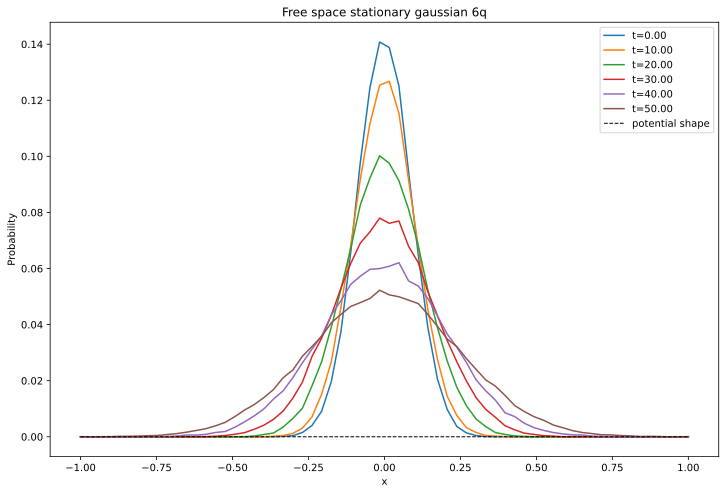

In [11]:
save_figure(counts_sg, xs, vs, f"Free space stationary gaussian {n}q", dt, iteration)

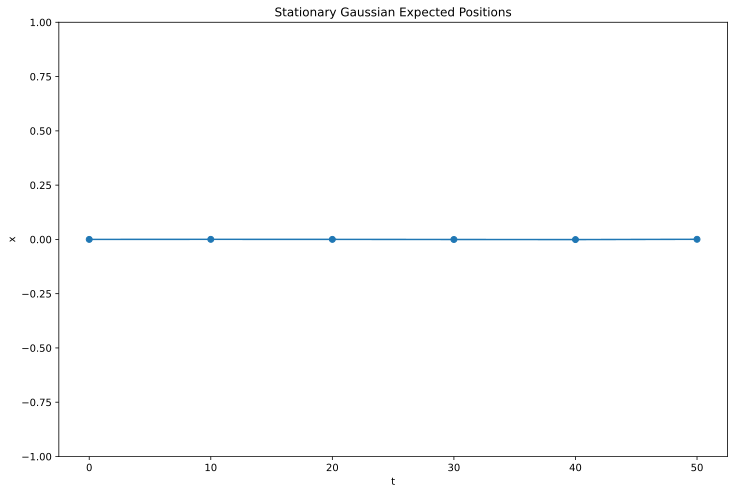

In [15]:
l = len(counts_sg)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep+1)
pos = np.empty(l)
for i in range(l):
    t[i] = i*dt*iteration
    pos[i] = np.sum(counts_sg[i]*xs)
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, pos, marker='o')
ax.set(title="Stationary Gaussian Expected Positions", xlabel="t", ylabel="x", ylim=[-1,1])
plt.savefig("Stationary Gaussian Pos.pdf", bbox_inches='tight')
plt.show()

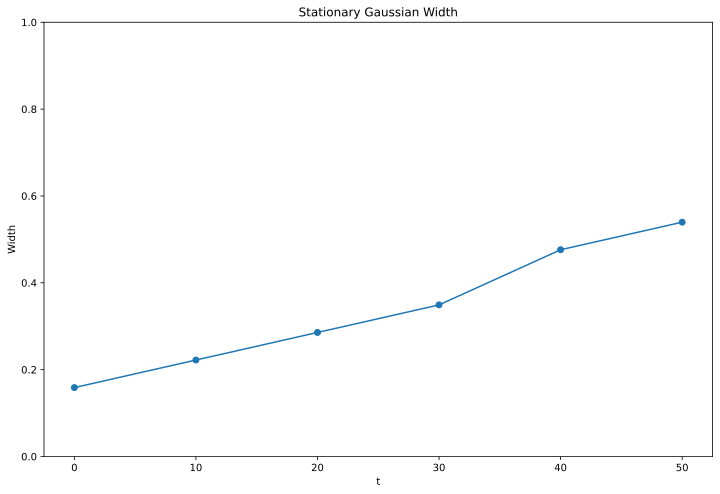

In [48]:
l = len(counts_sg)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep+1)
width = np.empty(l)
for i in range(l):
    max_val = max(counts_sg[i])
    idxs = np.where(np.array(counts_sg[i]) >= max_val/2)[0]
    t[i] = i*dt*iteration
    width[i] = xs[idxs[-1]]-xs[idxs[0]]
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, width, marker='o')
ax.set(title="Stationary Gaussian Width", xlabel="t", ylabel="Width", ylim=[0,1])
plt.savefig("Stationary Gaussian Width.pdf", bbox_inches='tight')
plt.show()

## Moving Gaussian in Free space

In [16]:
xs = np.linspace(-1, 1, 2 ** n)
vs = np.zeros(2**n)
initial_state=np.exp(-25*xs**2)*np.exp(5j*xs)

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_mg=evolve(n, dt, iteration, timestep, initial_state, vs, backend_qasm, 65536)

step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done


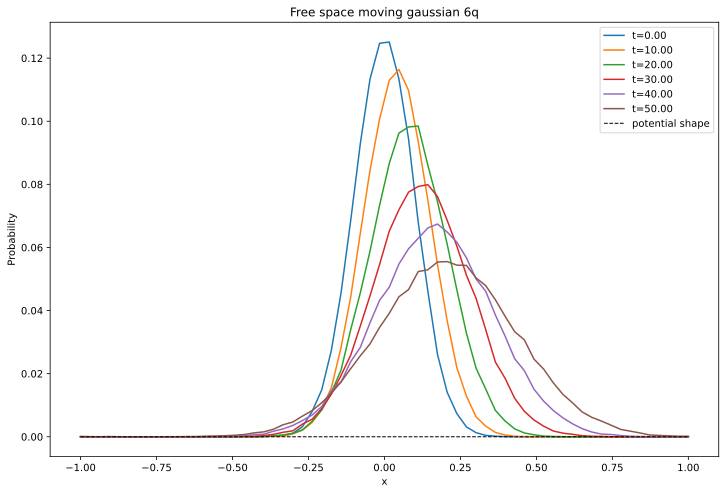

In [17]:
save_figure(counts_mg, xs, vs, f"Free space moving gaussian {n}q", dt, iteration)

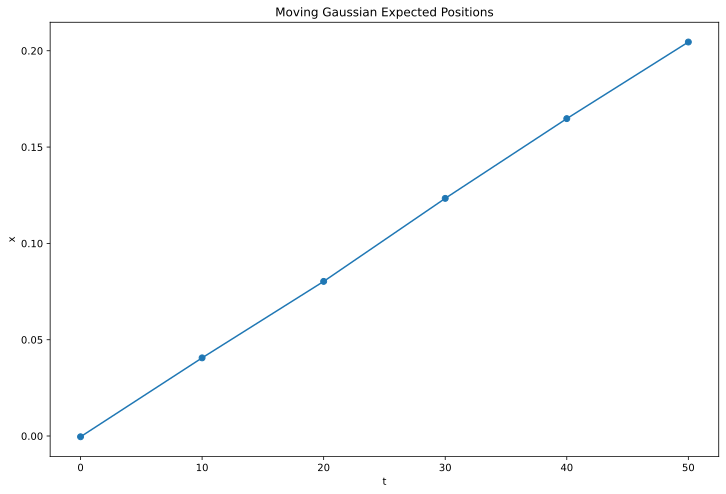

In [34]:
l = len(counts_mg)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep+1)
pos = np.empty(l)
for i in range(l):
    t[i] = i*dt*iteration
    pos[i] = np.sum(counts_mg[i]*xs)
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, pos, marker='o')
ax.set(title="Moving Gaussian Expected Positions", xlabel="t", ylabel="x")
plt.savefig("Moving Gaussian Pos.pdf", bbox_inches='tight')
plt.show()

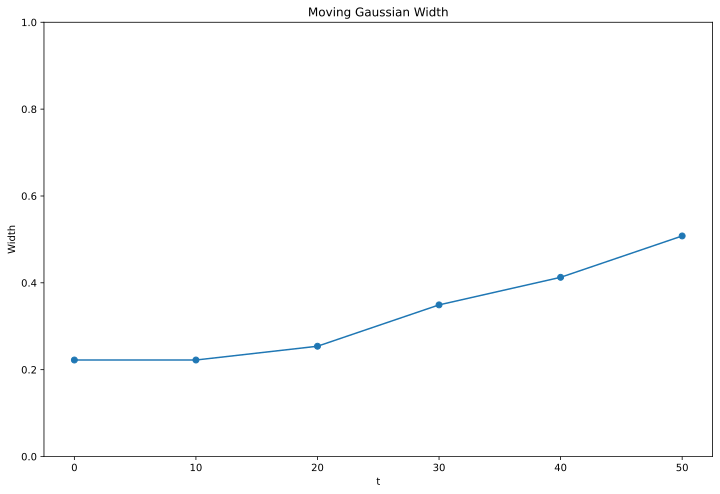

In [47]:
l = len(counts_mg)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep+1)
width = np.empty(l)
for i in range(l):
    max_val = max(counts_mg[i])
    idxs = np.where(np.array(counts_mg[i]) >= max_val/2)[0]
    t[i] = i*dt*iteration
    width[i] = xs[idxs[-1]]-xs[idxs[0]]
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, width, marker='o')
ax.set(title="Moving Gaussian Width", xlabel="t", ylabel="Width", ylim=[0,1])
plt.savefig("Moving Gaussian Width.pdf", bbox_inches='tight')
plt.show()

## Square Well

In [19]:
xs = np.linspace(-1, 1, 2 ** n)
vs = np.zeros(2**n)
vs[2**(n-1):]=1
initial_state = np.zeros(2**n)
initial_state[:2**(n-1)] = np.sin(np.pi*xs)[:2**(n-1)]

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_sw=evolve(n, dt, iteration, timestep, initial_state, vs, backend_qasm, 65536)

step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done


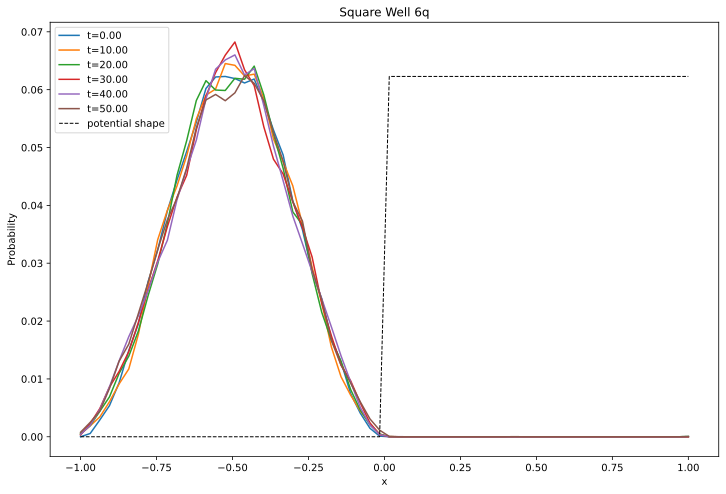

In [20]:
save_figure(counts_sw, xs, vs, f"Square Well {n}q", dt, iteration)

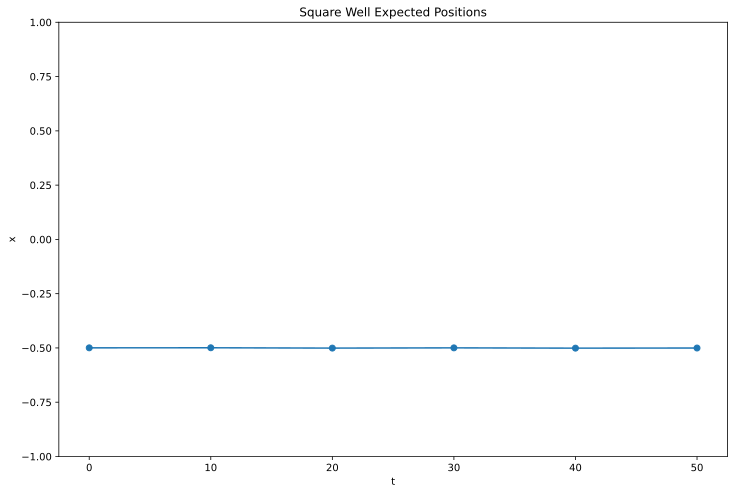

In [35]:
l = len(counts_sw)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep+1)
pos = np.empty(l)
for i in range(l):
    t[i] = i*dt*iteration
    pos[i] = np.sum(counts_sw[i]*xs)
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, pos, marker='o')
ax.set(title="Square Well Expected Positions", xlabel="t", ylabel="x", ylim=[-1,1])
plt.savefig("Square Well Pos.pdf", bbox_inches='tight')
plt.show()

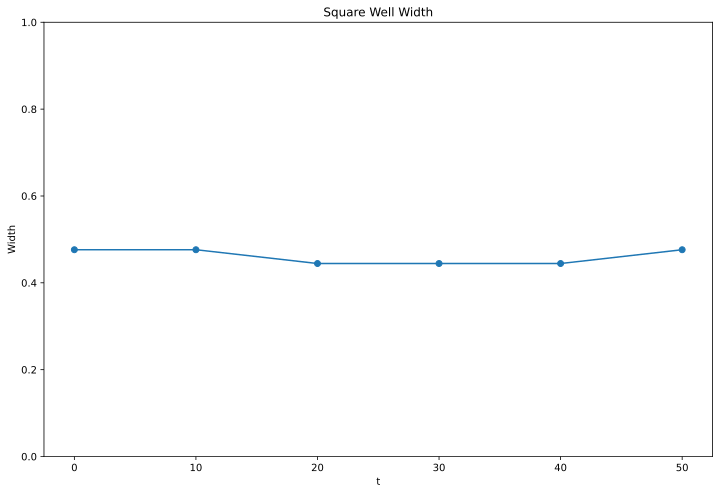

In [49]:
l = len(counts_sw)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep+1)
width = np.empty(l)
for i in range(l):
    max_val = max(counts_sw[i])
    idxs = np.where(np.array(counts_sw[i]) >= max_val/2)[0]
    t[i] = i*dt*iteration
    width[i] = xs[idxs[-1]]-xs[idxs[0]]
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, width, marker='o')
ax.set(title="Square Well Width", xlabel="t", ylabel="Width", ylim=[0,1])
plt.savefig("Square Well Width.pdf", bbox_inches='tight')
plt.show()

## Double Well

In [36]:
xs = np.linspace(-1, 1, 2 ** n)
vs = np.zeros(2**n)
vs[2**(n-2):2**(n-1)]=0.5
vs[2**(n-2)+2**(n-1):]=0.5
initial_state = np.zeros(2**n)
initial_state[:2**(n-2)] = np.sin(2*np.pi*xs)[:2**(n-2)]

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_dw=evolve(n, dt*10, iteration*3, timestep, initial_state, vs, backend_qasm, 65536)

step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done


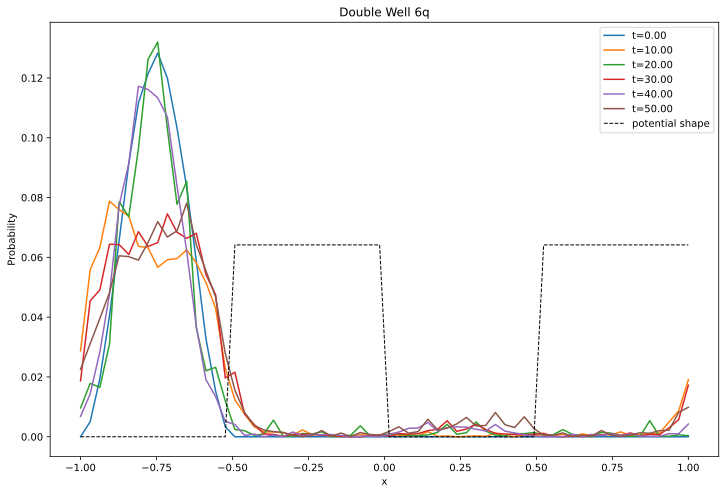

In [37]:
save_figure(counts_dw, xs, vs, f"Double Well {n}q", dt, iteration)

## Harmonic Coherent

In [23]:
xs = np.linspace(-1, 1, 2 ** n)
vs = xs**2
vs/=vs[0]
initial_state = np.exp(-((xs-0.6)*5.95)**2)

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_hc=evolve(n, dt, iteration, timestep, initial_state, vs, backend_qasm, 65536)

step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done


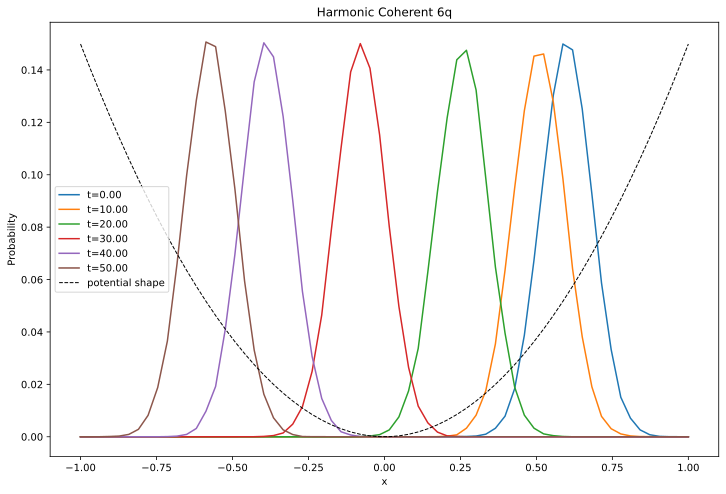

In [24]:
save_figure(counts_hc, xs, vs, f"Harmonic Coherent {n}q", dt, iteration)

In [25]:
xs = np.linspace(-1, 1, 2 ** n)
vs = xs**2
vs/=vs[0]
initial_state = np.exp(-((xs-0.6)*5.95)**2)

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_hc3=evolve(n, dt, iteration, timestep*3, initial_state, vs, backend_qasm, 65536)

step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done
step 6 done
step 7 done
step 8 done
step 9 done
step 10 done
step 11 done
step 12 done
step 13 done
step 14 done
step 15 done


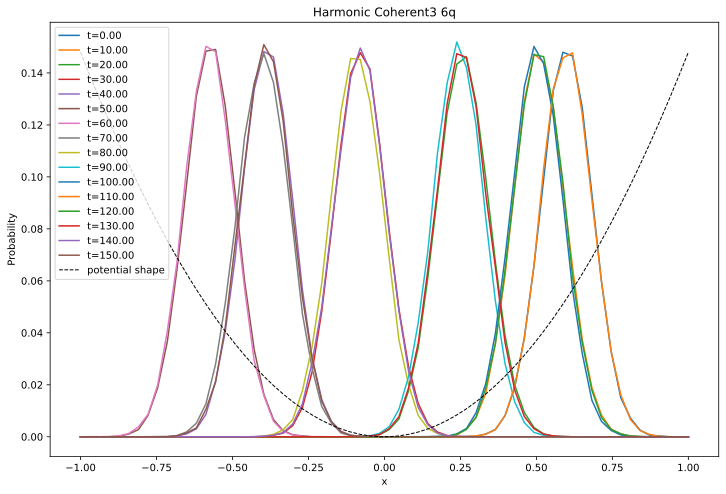

In [26]:
save_figure(counts_hc3, xs, vs, f"Harmonic Coherent3 {n}q", dt, iteration)

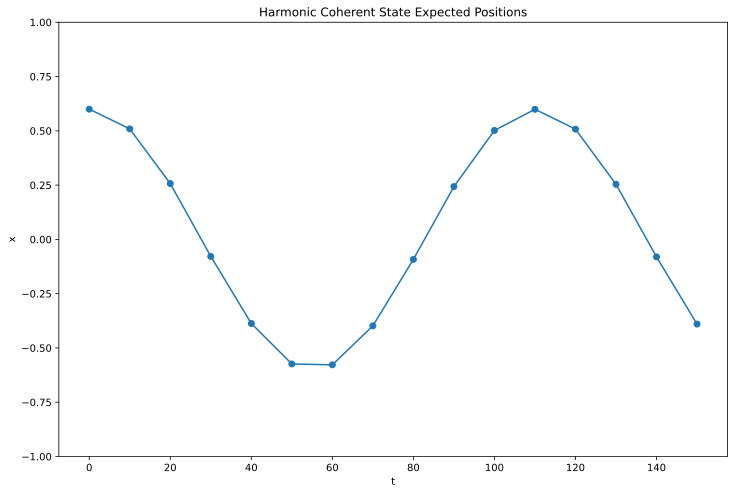

In [27]:
l = len(counts_hc3)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep*3+1)
pos = np.empty(l)
for i in range(l):
    t[i] = i*dt*iteration
    pos[i] = np.sum(counts_hc3[i]*xs)
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, pos, marker='o')
ax.set(title="Harmonic Coherent State Expected Positions", xlabel="t", ylabel="x", ylim=[-1,1])
plt.savefig("Harmonic Coherent Pos.pdf", bbox_inches='tight')
plt.show()

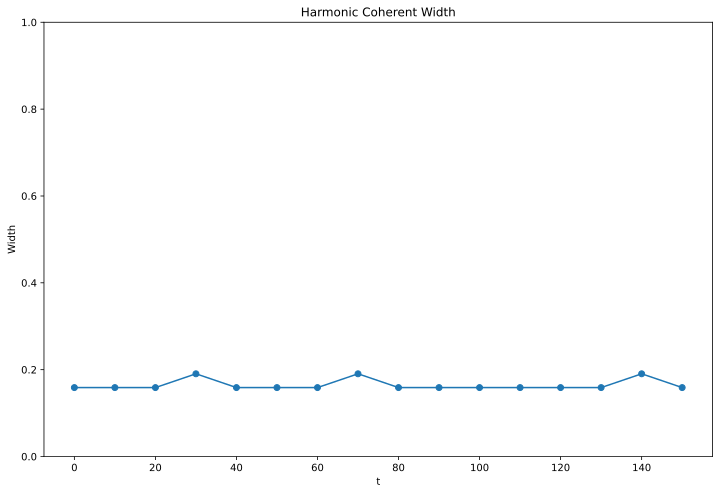

In [50]:
l = len(counts_hc3)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep*3+1)
width = np.empty(l)
for i in range(l):
    max_val = max(counts_hc3[i])
    idxs = np.where(np.array(counts_hc3[i]) >= max_val/2)[0]
    t[i] = i*dt*iteration
    width[i] = xs[idxs[-1]]-xs[idxs[0]]
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, width, marker='o')
ax.set(title="Harmonic Coherent Width", xlabel="t", ylabel="Width", ylim=[0,1])
plt.savefig("Harmonic Coherent Width.pdf", bbox_inches='tight')
plt.show()

## Harmonic Eigen

In [31]:
xs = np.linspace(-1, 1, 2 ** n)
vs = xs**2
vs/=vs[0]
initial_state = np.exp(-((xs)*5.95)**2)

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_he=evolve(n, dt, iteration, timestep, initial_state, vs, backend_qasm, 65536)

step 0 done
step 1 done
step 2 done
step 3 done
step 4 done
step 5 done


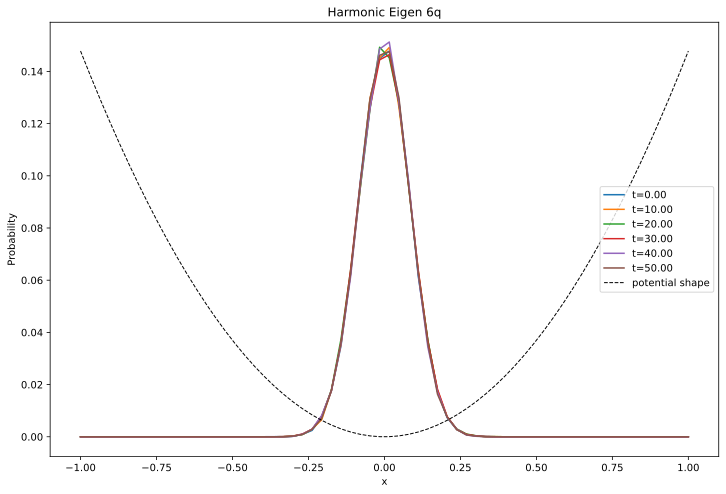

In [32]:
save_figure(counts_he, xs, vs, f"Harmonic Eigen {n}q", dt, iteration)

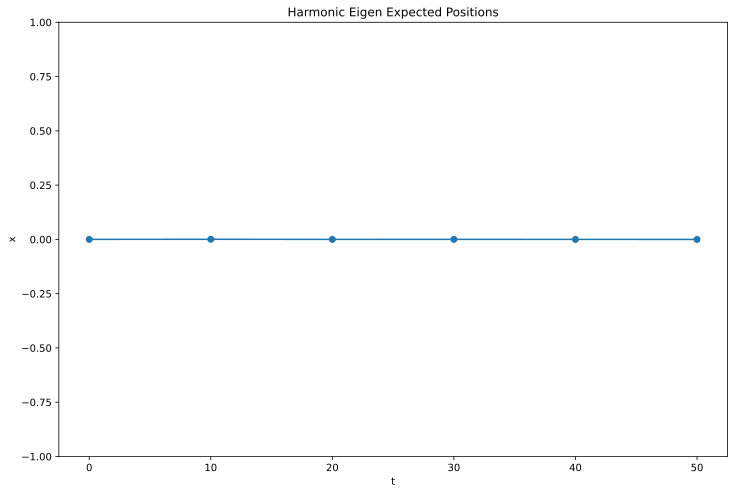

In [45]:
l = len(counts_he)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep+1)
pos = np.empty(l)
for i in range(l):
    t[i] = i*dt*iteration
    pos[i] = np.sum(counts_he[i]*xs)
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, pos, marker='o')
ax.set(title="Harmonic Eigen Expected Positions", xlabel="t", ylabel="x", ylim=[-1,1])
plt.savefig("Harmonic Eigen Pos.pdf", bbox_inches='tight')
plt.show()

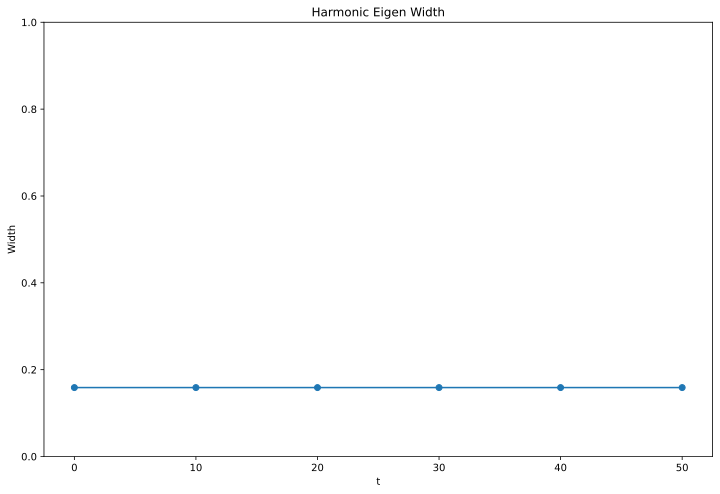

In [51]:
l = len(counts_he)
xs = np.linspace(-1,1,2**n)
t = np.empty(timestep+1)
width = np.empty(l)
for i in range(l):
    max_val = max(counts_he[i])
    idxs = np.where(np.array(counts_he[i]) >= max_val/2)[0]
    t[i] = i*dt*iteration
    width[i] = xs[idxs[-1]]-xs[idxs[0]]
    
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(t, width, marker='o')
ax.set(title="Harmonic Eigen Width", xlabel="t", ylabel="Width", ylim=[0,1])
plt.savefig("Harmonic Eigen Width.pdf", bbox_inches='tight')
plt.show()

# Real QC

In [ ]:
n = 4; ## number of qubits
dt = 0.05; ##time of evolution 
iteration = 20; 

## Stationary Gaussian in Free space

In [ ]:
xs = np.linspace(-1, 1, 2 ** n)
vs = np.zeros(2**n)
initial_state=np.exp(-25*xs**2)

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_sgr=evolve(n, 0.1, iteration, initial_state, vs, backend_manila, 16384)
save_figure(counts_sgr, vs, "Free space stationary gaussian 4q real QC", dt)

## Square Well

In [ ]:
xs = np.linspace(-1, 1, 2 ** n)
vs = np.zeros(2**n)
vs[2**(n-1)-1:]=1
initial_state = np.zeros(2**n)
initial_state[:2**(n-1)] = np.sin(np.pi*xs)[:2**(n-1)]

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude

counts_swr=evolve(n, dt, iteration, initial_state, vs, backend_manila, 16384)
save_figure(counts_swr, vs, "Square Well 4q real QC", dt)

##

##